# Machine Learning in Python

- Tools: scikit-learn (`sklearn`)
    - Data Partitioning
    - Feature selection
    - Modeling: SVM
    - Model Assessment
    
 [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/COGS108/Lectures-Fa23/blob/main/Week_07/07_19_ml.ipynb)


For more reading on scikit-learn (`sklearn`) and machine learning in Python: https://scikit-learn.org/stable/index.html

# Machine Learning: General Steps

1. Data Partitioning
2. Feature Selection
3. Model
4. Model Assessment

## Setup

In [1]:
# import ds/plotting packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Import nltk package 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# import random for randomizing
import random

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# scikit-learn imports
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Uncomment if you need to download the NLTK English tokenizer and the stopwords of all languages
# nltk.download('punkt')
# nltk.download('stopwords')

# Example: Class Responses

## Data

Student responses on COGS 108 Mid-course survey to the following two questions: 

- What have you enjoyed MOST about COGS 108 so far? Please explain.
- What have you enjoyed LEAST about COGS 108 so far? Please explain.

In [58]:
# read data in
# 1 = most; 0 = least
df = pd.read_csv('https://raw.githubusercontent.com/shanellis/datasets/master/COGS108_ml.csv', encoding="ISO-8859-1")
df.tail()

,response,most_least,quarter
3454,I can't say that there's bad about this course.,0,sp21
3455,"Aside from the lecture time, which can't be he...",0,sp21
3456,"I don't think this is really an issue at all, ...",0,sp21
3457,Nothing in particular,0,sp21
3458,It has been hard making it to lectures in the ...,0,sp21


In [4]:
# randomly sort data frame
df = df.sample(frac=1, random_state=200).reset_index(drop=True)
df.head()

,response,most_least,quarter
0,I don't understand some basic aspects of pushi...,0,fa20
1,Working with my group has been a little frustr...,0,wi21
2,The consistent amount of assignments,0,wi21
3,The lectures are honestly super interesting an...,1,sp19
4,Self-paced lectures,1,fa20


Randomly sorted data frame:
- for selection of training and test set
- will be approximately balanced between outcomes in each

In [5]:
# see how much data we're working with
df.shape

(3459, 3)

In [6]:
df.groupby('quarter')['response'].count()

quarter
fa20    551
sp19    631
sp20    705
sp21    466
wi20    491
wi21    615
Name: response, dtype: int64

### Train,  Validate, Test

- Training set is what we use for creating the model
- Validation set is what we use for fine tuning the model -- checking which hyper-parameters are best
- Test set is what we use to figure out how good the model will do next year with new data arriving

#### Method (1) - Manual split, split by quarter

- We'll test the model on one quarter's responses
- We'll validate the model on another quarter's responses
- We'll train the model on everything else





In [59]:


## Validation
df_validation = df[df['quarter']=='sp20']
              
## Test
df_test = df[df['quarter']=='sp19']

## Train
df_train = df[~df['quarter'].isin(['sp19','sp20'])]


In [60]:
print(df_train.shape, df_validation.shape, df_test.shape)

(2123, 3) (705, 3) (631, 3)


#### Clicker Question #1

How well do you think we will be able to predict whether a student comment is a response to what they liked most vs what they liked least in our ***training*** dataset?

- A) Accuracy ~0%
- B) Accuracy ~25%
- C) Accuracy ~50%
- D) Accuracy ~75%
- E) Accuracy ~100%

#### Clicker Question #2

How well do you think we will be able to predict whether a student comment is a response to what they liked most vs what they liked least in our ***validation*** dataset?

- A) Accuracy ~0%
- B) Accuracy ~25%
- C) Accuracy ~50%
- D) Accuracy ~75%
- E) Accuracy ~100%

#### Thinking this through

Is this a good idea to split up by quarter?  What could happen here?

#### Method (2) - sklearn split, randomize the data
- Training set 60% of the data randomly mixed across quarters
- Validation set 20% of the data randomly mixed across quarters
- Test set 20% of the data randomly mixed across quarters

In [9]:
from sklearn.model_selection import train_test_split

X_trainvalid, X_test, Y_trainvalid, Y_test = train_test_split(
    df['response'], df['most_least'], test_size=0.2, random_state=42)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_trainvalid, Y_trainvalid, test_size=0.25

)

print(X_train.shape, X_valid.shape, X_test.shape)

(2075,) (692,) (692,)


## Prediction Task: 

**Classify text from students as 'most liked' or 'least liked'**

#### 11 Steps to Prediction:

1. Specify parameters for TF-IDF calculation
2. Calculate TF-IDF from text input (predictors)
3. Extract most or least (outcome)
4. Specify how data will be partitioned
5. Partition the data
6. Train model
7. Predict in training
8. Predict in testing
9. Assess accuracy in training
10. Assess accuracy in test set
11. IF NEEDED: Model selection + test process that replaces steps 6-10 

### Data Processing

Step 1: Determine how you'll convert a collection of raw documents to a matrix of TF-IDF features.

In [61]:
# Create vectorizer & specify parameters
tfidf = TfidfVectorizer(sublinear_tf=True, #apply sublinear TF scaling
                        analyzer='word',   #specify tokenizer
                        max_features=500, # specify max # of features to include
                        tokenizer=word_tokenize)

* sublinear TF scaling - replaces term frequency (TF) with $1 + log(TF)$

Step 2: Generate matrix of TF-IDF features.

In [62]:
# Learn vocabulary and idf, return term-document matrix.
# return an array;our predictor
tfidf_X = tfidf.fit_transform(X_train).toarray()

# take a look at the output
print(tfidf_X.shape)

print("min: " , np.min(tfidf_X), '\n',
      "mean: ", np.mean(tfidf_X), '\n',
      "max: ",  np.max(tfidf_X))

(2075, 500)
min:  0.0 
 mean:  0.006929570278815825 
 max:  1.0


In [50]:
tfidf_X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [63]:
## get IDF to visualize
idf = tfidf.idf_
rr = dict(zip(tfidf.fit(X_train).get_feature_names(), idf))

token_weight = pd.DataFrame.from_dict(rr, orient='index').reset_index()
token_weight.columns=('token','weight')
token_weight = token_weight.sort_values(by='weight', ascending=False)
token_weight

,token,weight
394,step,6.558757
419,tests,6.558757
332,per,6.440974
177,forget,6.440974
287,minute,6.335613
...,...,...
44,and,1.952337
440,to,1.874313
226,i,1.710640
13,.,1.525871


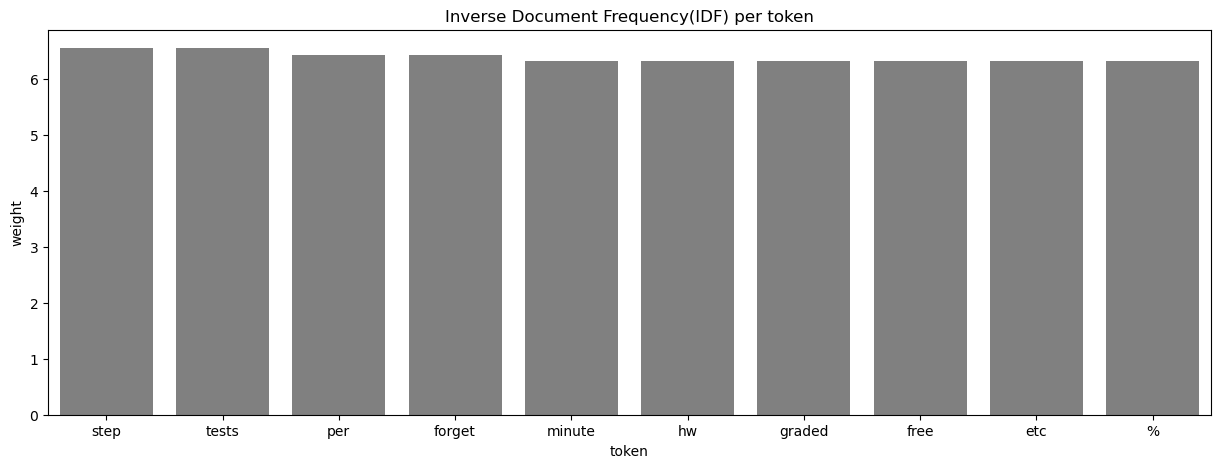

In [19]:
sns.barplot(x='token', 
            y='weight', 
            data=token_weight[0:10], 
            color="gray")            
plt.title("Inverse Document Frequency(IDF) per token")
fig = plt.gcf()
fig.set_size_inches(15,5);

Step 3: Extract outcome variable

In [20]:
# specify outcome variable
tfidf_Y = np.array(Y_train)
tfidf_Y

array([0, 1, 0, ..., 0, 0, 1])

In [21]:
tfidf_X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
tfidf_X.shape, tfidf_Y.shape

((2075, 500), (2075,))

#### Clicker Question #3

Looking at the code above and thinking about what we've done so far in this analysis, what is stored in `tfidf_Y`?

- A) predictor variable - training data
- B) outcome variable - training data
- C) predictor variable - test data
- D) outcome variable - test data
- E) validation DataFrame

# Avoiding data leakage with feature selection

NEVER do feature selection or feature transformation fitting on ALL of the data.

You don't want information about your validation and test set inside your training set.

If you fit your features on the whole dataset you have implictly told the training set information about the vocuabulary and frequency of things that aren't in the training set! BAD!

In [23]:
tfidf_train = tfidf.fit_transform(X_train)
tfidf_valid = tfidf.transform(X_valid)
tfidf_test = tfidf.transform(X_test)

In [24]:
tfidf_train.shape, tfidf_valid.shape, tfidf_test.shape

((2075, 500), (692, 500), (692, 500))

## Model

### SVM: Support Vector Machines

- simple & interpretable machine learning model
- based in linear regression
- classification task
- supervized
    - input: labeled training data
    - model determines hyperplane that best discriminates between categories

### SVM: Tuning Parameters
- **regularization** parameter
    - can determine how this line is drawn
    - can increase accuracy of prediction
    - can lead to overfitting of the data
- **kernel** parameter
    - specifies how to model & transform data
    

For more reading on SVMs using `sklearn`: https://scikit-learn.org/stable/modules/svm.html

OR just scroll to the very end of this notebook where we get a bit crazy with them 

### Model Generation
    

Step 6: Generate and train the model.

In [25]:
# uncomment to read documentation for model
SVC?

In [64]:
# function we'll use to run the model

svm_model = SVC(kernel='linear')
type(svm_model)

sklearn.svm._classes.SVC

In [65]:
# train model
svm_model = svm_model.fit(tfidf_train, Y_train)


In [28]:
svm_model.coef_.todense()

matrix([[ 6.54323375e-01, -1.92733128e-01,  5.18243338e-01,
         -2.64506222e-01, -6.67275003e-01, -8.27289201e-01,
          3.19862803e-01, -1.71244565e-01,  2.06930492e-01,
         -1.15659832e+00,  3.34954593e-01, -3.84160247e-01,
          1.48308333e-01,  7.37714923e-01, -8.20993423e-01,
         -1.44050777e-01,  6.74582603e-01,  1.73278702e-01,
         -1.70365266e+00, -1.02260423e+00, -4.74983515e-01,
          5.41178350e-01, -2.64506222e-01, -3.17210076e-01,
          2.26194293e-01, -5.71429712e-02,  1.44782169e+00,
          3.36359429e-01,  4.39691991e-01,  7.64786828e-01,
          1.97114176e-01, -1.00670098e-01,  1.11863216e+00,
          5.09903093e-01, -9.59245147e-01,  1.66776611e+00,
         -7.71523872e-01, -2.25663901e-01,  1.95249898e-01,
         -3.45902429e-01, -9.80165811e-01, -2.26029869e-01,
          1.31698074e+00,  2.13321811e-01,  1.13406479e+00,
          4.32132610e-01, -6.46289301e-01, -1.09556921e-01,
         -7.45912223e-01,  5.48680295e-0

### Training Data

Step 7: Predict in the training data

In [29]:
# predict on training
df_predicted_train_Y = svm_model.predict(tfidf_train)

print(df_predicted_train_Y[0:5])
print(Y_train[0:5])

[0 1 0 0 0]
994     0
2947    1
2765    0
2430    0
636     0
Name: most_least, dtype: int64


In [30]:
# see how many were predicted most vs. least
pd.Series(df_predicted_train_Y).value_counts()

1    1080
0     995
dtype: int64

### Testing Data

Step 8: Predict in the testing data

In [54]:
# predict on training
df_predicted_test_Y = svm_model.predict(tfidf_test)
print(df_predicted_test_Y[0:5])
print(Y_test[0:5])

[0 0 1 1 1]
665     0
410     0
2686    1
2222    1
2609    1
Name: most_least, dtype: int64


In [32]:
# see how many were predicted most vs. least
pd.Series(df_predicted_test_Y).value_counts()

1    371
0    321
dtype: int64

## Accuracy Assessment

- RMSE (continuous)
- Accuracy, Sensitivity, Specificity, AUC
    - TP, TN, FP, FN

![confusion matrix](https://miro.medium.com/max/924/1*7EYylA6XlXSGBCF77j_rOA.png)

![sensitivity recell](https://miro.medium.com/max/878/1*Ub0nZTXYT8MxLzrz0P7jPA.png)

**Accuracy** - What % were predicted correctly?  
**Sensitivity (Recall)** - Of those that were positives, what % were predicted to be positive?  ; $\frac {TP}{(TP + FN)}$  
**Specificity** - Of those that were actually negatives, what % were predicted to be negative?  $\frac {TN}{(TN + FP)}$

**Precision (Positive Predictive Value, PPV)** = $\frac {TP}{(TP + FP)}$

- probability that predicted positive truly is positive

### Training Data

Step 9: Assess accuracy in training data

In [33]:
print(classification_report(Y_train, df_predicted_train_Y))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      1001
           1       0.92      0.93      0.92      1074

    accuracy                           0.92      2075
   macro avg       0.92      0.92      0.92      2075
weighted avg       0.92      0.92      0.92      2075



In [34]:
# where 'support' comes from
pd.Series(Y_train).value_counts()

1    1074
0    1001
Name: most_least, dtype: int64

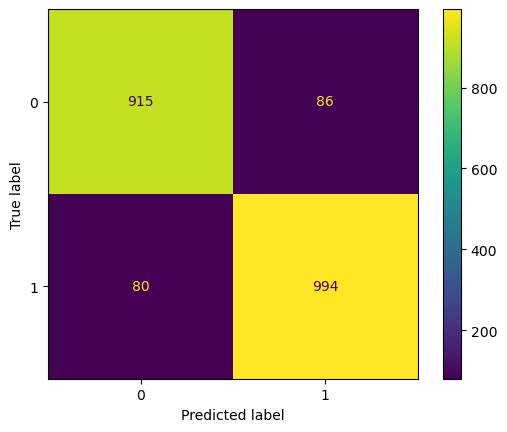

In [35]:
cm = confusion_matrix(Y_train, df_predicted_train_Y)
disp = ConfusionMatrixDisplay(cm)
disp.plot();


**support** - the number of occurrences of each class  
**precision (PPV)** - ability of the classifier not to label a positive sample as negative  
**recall (sensitivity)** - ability of the classifer to find all the positive samples


**f1-score** - weighted harmonic mean of the precision and recall; score reaches its best value at 1 and worst score at 0  
**macro average** - averaging the unweighted mean per label  
**weighted average** - averaging the support-weighted mean per label  
**micro average** - averaging the total true positives, false negatives and false positives

### Testing Data

Step 10 or 11: Assess accuracy in testing data

In [36]:
print(classification_report(Y_test, df_predicted_test_Y))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       320
           1       0.88      0.88      0.88       372

    accuracy                           0.87       692
   macro avg       0.87      0.87      0.87       692
weighted avg       0.87      0.87      0.87       692



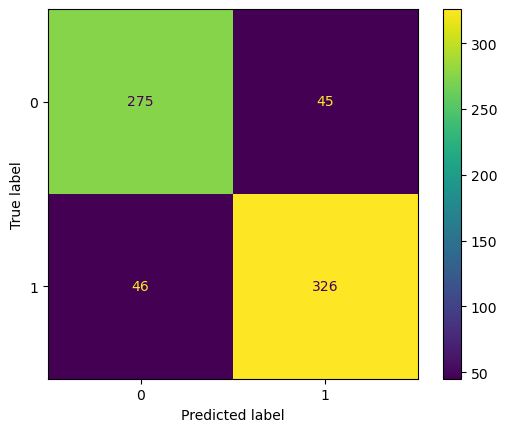

In [37]:
cm = confusion_matrix(Y_test, df_predicted_test_Y)
disp = ConfusionMatrixDisplay(cm)
disp.plot();

#### Clicker Question #4

Given this output, would you use this model to predict whether or not text was something someone liked or disliked about COGS 108?

- A) Yes
- B) No
- C) Unsure

### Doing model selection with the validation data

Actually, usually BEFORE you test, you'll want to play with hyperparameters in validation to get the best result.  Fine tuning your model.


So consider this an optional step, that usually comes before test if your model has a set of knobs and dials to twiddle.  

We only did test first above to build some intuition for you.

In [57]:
# play with the parameter C until it looks good
svm_model = SVC(kernel='linear', C=1000000)
svm_model.fit(tfidf_train, Y_train)
df_predicted_validation_Y = svm_model.predict(tfidf_valid)

# assess accuracy
cm = confusion_matrix(Y_valid, df_predicted_validation_Y)
disp = ConfusionMatrixDisplay(cm)
disp.plot();

print(classification_report(Y_valid, df_predicted_validation_Y))

KeyboardInterrupt: 

              precision    recall  f1-score   support

           0       0.84      0.81      0.82       320
           1       0.84      0.86      0.85       372

    accuracy                           0.84       692
   macro avg       0.84      0.84      0.84       692
weighted avg       0.84      0.84      0.84       692



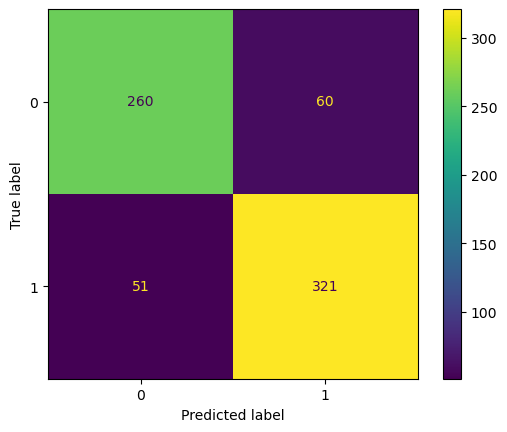

In [41]:
#assuming we left the cell above with our BEST model setting
# lets refit it with all of train+valid sets
svm_model.fit(np.concatenate([tfidf_train.todense(), tfidf_valid.todense()]), 
              np.concatenate([Y_train, Y_valid]))

# get test set predictions
df_predicted_test_Y = svm_model.predict(tfidf_test.todense())

print(classification_report(Y_test, df_predicted_test_Y))

cm = confusion_matrix(Y_test, df_predicted_test_Y)
disp = ConfusionMatrixDisplay(cm)
disp.plot();

### Summary

1. 80:20 Partition
2. Specified TF-IDF as predictor and most/least (0,1) as outcome
3. Trained SVM linear classifier
4. Built model on Training data
5. Predicted in training data and on testing data
6. Assessed overall accuracy

### Approaches For Improvement?

- Data Cleaning/Stemming
- Different Tuning Parameters?
- Cross-Validation?
- Train/Test on all data OR Train only Sp20/Fa20/Wi21 (remote quarters)
- Different Model?

To start with use sklearn the EASY way... don't try to hand code things like Train-Test split or K-Fold cross-validation... read the docs and learn how to use these wonderful functions https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

In [47]:
from sklearn.model_selection import cross_val_score
results = cross_val_score(svm_model, 
                         X=np.concatenate([tfidf_train.todense(), tfidf_valid.todense()]), 
                         y=np.concatenate([Y_train, Y_valid]),
                         cv=5) 
import numpy as np
np.mean(results)

0.8164060816942049

## Feature engineering
One thing we didn't talk about is how you need to engineer features for NON-text kinds of inputs

In general this is a huge topic that I will try condense for you into two bullet points.

- If your data has different kinds of continuous variables, and especially if some of those variables tend to be big numbers (distance to the moon in meters) and some tend to be small numbers (the earths mass as a fraction of the earth's mass), then you need to STANDARDIZE those two variables to have roughly the same magnitude. If you don't then the ML system may think that the large magnitude variable is more predictive than the small magnitude variable.  See this link https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler
- If your data has categorical variables that do not have a natural order to them (red is not greater than blue), then you need to ONE-HOT encode those categorical variables.  Otherwise your ML system will think that red is greater than blue and that can make for some bad predictions.  See this link https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features

OK lets talk about how to do things with the non text input...

In [66]:
import numpy as np
import seaborn as sns
import pandas as pd 

%matplotlib inline

# lets get some 🐧 data to work with
df = sns.load_dataset('penguins').dropna()

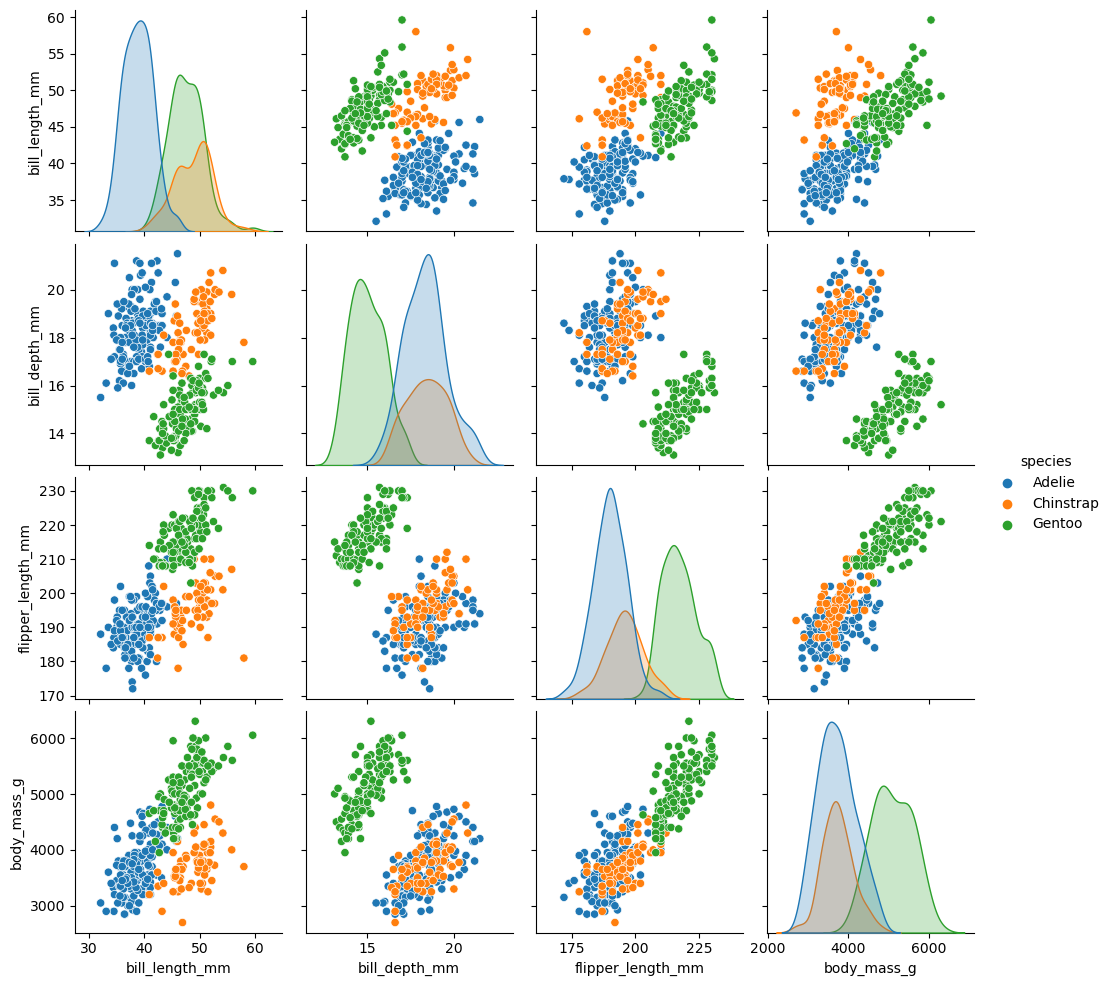

In [67]:
sns.pairplot(df, hue='species');

Hmm... lets take a close look at body mass vs bill length.... that seems really promising!!

Let's imagine what it would be like to use k-Nearest Neighbors on only those two inputs... it might be enough to make things predict well!

In [68]:
# what we want to predict
y = df['species']
# the data we will predict from
X = df[['bill_length_mm','body_mass_g']]

X

,bill_length_mm,body_mass_g
0,39.1,3750.0
1,39.5,3800.0
2,40.3,3250.0
4,36.7,3450.0
5,39.3,3650.0
...,...,...
338,47.2,4925.0
340,46.8,4850.0
341,50.4,5750.0
342,45.2,5200.0


UGH!!! the vector difference $\mathbf{x}_{new} -  \mathbf{x}_{i}$ is going to be absolutely dominated by body mass... it's two orders of magnitude bigger than bill length!

We may not want that!  From the scatterplot it looks like both variables are equally contibuting to understanding species.

We need to normalize the data so each variable is a z-scored version of itself... that means both variables will now be on roughly the same order of magnitued (about -3 to 3).  There are in fact many diffrerent kinds of normalization that could work here!  Take a look at this list: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

In [69]:
from sklearn.preprocessing import StandardScaler

preproc = StandardScaler()

preproc.fit(X)
scaled_data = preproc.transform(X)
X['bill_length_mm'] = scaled_data[:,0]
X['body_mass_g'] = scaled_data[:,1]

X

# some things to note here... we could just use scaled_data instead of stuffing
# the results back into the dataframe X... I'm just doing this so we can keep
# the column labels intact... scaled_data is a numpy ndarray without those labels
# sklearn will accept numpy arrays or pandas dataframes/series or any other iterable 
# as input, so use whatever you want

,bill_length_mm,body_mass_g
0,-0.896042,-0.568475
1,-0.822788,-0.506286
2,-0.676280,-1.190361
4,-1.335566,-0.941606
5,-0.859415,-0.692852
...,...,...
338,0.587352,0.892957
340,0.514098,0.799674
341,1.173384,1.919069
342,0.221082,1.234995


For categorical data inputs we usually wish to use a one-hot encoding.

One-hotting a single categorical variable that has N possible categories makes a vector representation that is N long. Because one-hot assumes each category is mutually exclusive with every other category, only one of those N category holders is allowed to be non-zero.

Why use one-hot encoding?  This eliminates unwanted "fake relationships" in categorical data that a different encoding might cause an ML system to learn.

Imagine we have categories like (red, blue, green). There is no ordinal relationship here... red is not > blue, nor is blue > green.  But if we turned (red, blue, green) into a representation like (3, 2, 1) that is exactly what our ML system would learn. Even worse, it would be more likely to confuse blue and green than red and green... because blue-green is smaller than red-green.

One hot eliminates this because the 3 long vectors representing each color [1, 0, 0], [0, 1,0], and [0, 0, 0] are orthogonal (unrelated).

In [80]:
from sklearn.preprocessing import OneHotEncoder

preproc = OneHotEncoder()

onehot = preproc.fit_transform(df[['island','sex']])
print(df[['island','sex']])
print(onehot.todense())

# there are 3 different islands, so 3 columns get used to encode which island
# only 1 of those 3 columns can be "hot" (non-zero) for each penguin
# likewise there are 2 different sexes recorded here, so 2 columns get used

        island     sex
0    Torgersen    Male
1    Torgersen  Female
2    Torgersen  Female
4    Torgersen  Female
5    Torgersen    Male
..         ...     ...
338     Biscoe  Female
340     Biscoe  Female
341     Biscoe    Male
342     Biscoe  Female
343     Biscoe    Male

[333 rows x 2 columns]
[[0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0.]
 [0. 0. 1. 1. 0.]
 ...
 [1. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1.]]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

pclassifier = KNeighborsClassifier(n_neighbors=15)

pclassifier.fit(X,y)
predicted = pclassifier.predict(X)

print(classification_report(y,predicted))

cm = confusion_matrix(y,predicted)
disp = ConfusionMatrixDisplay(cm)
disp.plot();

This result shows us that with just 2 variables we can get to 95% accuracy!

BUT note this is TRAINING SET accuracy... something of limited use.

Let's figure out how to make a training set/test set



In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=777)

print('training/test set sizes')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print()

pclassifier = KNeighborsClassifier(n_neighbors=15)

pclassifier.fit(X_train, y_train)
predicted_train = pclassifier.predict(X_train)
predicted_test = pclassifier.predict(X_test)

print('training set performance')
print(classification_report(y_train,predicted_train))
print()
print('test set performance')
print(classification_report(y_test,predicted_test))
print()
print('test set confusion matrix')
cm = confusion_matrix(y_test,predicted_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot();

Well what if instead of train/test, we do cross validation?

In [ ]:
from sklearn.model_selection import cross_val_predict

print('lets do 5 fold cross validation...')
X_xval, X_test, y_xval, y_test = train_test_split( X, y, test_size=0.3, random_state=777)

print('xval/test set sizes')
print(X_xval.shape, X_test.shape, y_xval.shape, y_test.shape)
print()

pclassifier = KNeighborsClassifier(n_neighbors=15)

predicted_xval = cross_val_predict(pclassifier, X_xval, y_xval, cv=5)
predicted_test = pclassifier.fit(X_xval,y_xval).predict(X_test)

print('xval performance')
print(classification_report(y_xval,predicted_xval))
print()
print('test set performance')
print(classification_report(y_test,predicted_test))
print()
print('test set confusion matrix')
cm = confusion_matrix(y_test,predicted_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot();

Wow... but cross-validation is really useful for looking at the BEST set of hyperparameters possible... is there a way to do that?

In [ ]:
from sklearn.model_selection import GridSearchCV

print('lets do grid search using 5 fold cross validation... and this time lets use all the measurements not just the best two')
X = df[['bill_length_mm','bill_depth_mm','flipper_length_mm', 'body_mass_g']]
y = df['species']

preproc = StandardScaler()

preproc.fit(X)
scaled_data = preproc.transform(X)
X['bill_length_mm'] = scaled_data[:,0]
X['bill_depth_mm'] = scaled_data[:,1]
X['flipper_length_mm'] = scaled_data[:,2]
X['body_mass_g'] = scaled_data[:,3]

X_xval, X_test, y_xval, y_test = train_test_split( X, y, test_size=0.3, random_state=777)

print('xval/test set sizes')
print(X_xval.shape, X_test.shape, y_xval.shape, y_test.shape)
print()

# note we don't need to put n_neightbors here now :)
pclassifier = KNeighborsClassifier()
params = { 'n_neighbors':[1,3,5,7,9,11,13,15]}

searcher = GridSearchCV(pclassifier, param_grid=params, cv=5)

# at this point we run a bunch of cross validations
searcher.fit(X_xval, y_xval)



In [ ]:
# a fitted set of cvs, one for each param set in the grid
searcher.cv_results_

In [ ]:
# you can match this up with mean_test_score above
searcher.best_params_

In [ ]:
# searcher, when used as a classifier, uses the best_params_ by default
predicted_test = searcher.fit(X_xval,y_xval).predict(X_test)


print('test set performance')
print(classification_report(y_test,predicted_test))
print()
print('test set confusion matrix')
cm = confusion_matrix(y_test,predicted_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot();

## Support Vector Machines: Maximizing the *Margin*

Support vector machines are another ML technique

The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
Here is an example of how this might look:

In [ ]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

xfit = np.linspace(-1, 3.5)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=75);

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.

### Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.
For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

In [ ]:
dir(model)

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [ ]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=3, facecolors='none', edgecolor='k');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [ ]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=75);

plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure.
These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

In [ ]:
model.support_vectors_

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit!
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

In [ ]:
%matplotlib inline

def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=75, ax=ax)
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [30, 60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for just 10 training points, in the middle we see  60 training points and on the right panel 120 points.  While going from 30 to 60 caused changes, going from 60 to 120 did not becuase the support vectors (the points on the margin line) had not changed.

This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

### Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when it is combined with *kernels*.
We have seen a version of kernels before: Remember polynomial features from the regression lectures?  

There we projected our data into higher-dimensional space defined by polynomials functions, and thereby were able to fit for nonlinear relationships with a linear regression.

In SVM models, we can use a version of the same idea.
To motivate the need for kernels, let's look at some data that is not linearly separable:

In [ ]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=75);
plt.xlabel('x1')
plt.ylabel('x2');
#plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will *ever* be able to separate this data.

One simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

In [ ]:
phi = np.exp(-(X ** 2).sum(1))

Adding phi as a 3rd dimension gives us this:

In [ ]:
%matplotlib notebook

from mpl_toolkits import mplot3d
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette()[:2])

ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], phi, c=y, s=7, cmap=cmap)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('$\phi(\mathbf{x})_3$');


We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, *phi*=0.7.

Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.
In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.
This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection!
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:

In [ ]:
%matplotlib inline

In [ ]:
clf = SVC(kernel='polynomial', C=1E6)
clf.fit(X, y)

In [ ]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=75)
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none', edgecolor='k');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

### Tuning the SVM: Softening Margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this:

In [ ]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=75);

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
For very large $C$, the margin is hard, and points cannot lie in it.
For smaller $C$, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

In [ ]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=75, ax=axi)
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none', edgecolor='k');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar model selection procedure.


In fact in general we would want to do model selection on all the hyperparameters of the SVM... $C$, what kernel to use, and whatever hyperparameters are unique to each kernel like polynomial order in $\phi$.

In fact sklearn gives us a powerful tool to do exactly this. Which I will demonstrate below.

If you're actually following us all the way to this point you are getting into the territory of where I want you to be during this point in the quarter in COGS118A.  So if you are NOT following don't worry too much about it... this is advanced stuff 

In [ ]:
# NOTE: this will take around 2-3 minutes to run

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV


# what we want to predict
y = df['species']
# the data we will predict from... note that we will include SEX
# because penguin sex is actually pretty important in their size measurements
X = df.drop(columns=['island','species'])

# sex is a categorical variable... it needs to be one hot encoded!
# we know from before that we need to z-score the numeric variables

# here we setup a way to transform the categorical variables into one hot, 
# and to z-score the numeric variables.... completely automatically!!
# remember how we had to do this with a bunch of different
# steps manually the last time around??
# if you'd like to understand how to do this more generally
# search the sklearn docs for ColumnTransformer!
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

onehot = OneHotEncoder()
scaler = StandardScaler()

preprocessor = ColumnTransformer([
    ('onehot', onehot, categorical_columns),
    ('zscore', scaler, numerical_columns)])


# Create a pipeline 
# a pipeline puts together two (or 3 or however many) steps into one sklearn
# estimator. That means we can use pipe instead of svc in any xval or grid search
# and get the preprocessing done for us in the same step
pipe = Pipeline([('make_features', preprocessor),
                 ('classifier', SVC())])

# SVM have very different hyperparameters depending on which kernel
# potential hyperparams are gamma, coef0, degree and kernel.
# here <x,x'> and ||x-x'|| are similarities between two vectors x,x'
# linear kernel:     <x,x'>  [no hyperparams]
# poly kernel:       ( gamma * <x,x'> + coef0 )^degree 
# rbf kernel:        exp( - gamma * ||x-x'||^2 )
# sigmoid kernel:    tanh( gamma * <x,x'> + coef0 )

# so how can we search using only using hypers appropriate for each kernel?
# like this...make a list of different search spaces you want to execute
search_space = [{'classifier__kernel': ['linear'],
                 'classifier__C': np.logspace(-3, 2, 11) #11 steps between 10^-3 to 10^2
                },
                {'classifier__kernel': ['poly'],
                 'classifier__gamma': np.logspace(-3, 2, 11),
                 'classifier__degree': range(2,14),
                 # NOPE... this isnt often important 'classifier__coef0': np.logspace(-3, 2, 11),
                 'classifier__C': np.logspace(-3, 2, 11)
                },
                {'classifier__kernel': ['rbf'],
                 'classifier__gamma': np.logspace(-3, 2, 11),
                 'classifier__C': np.logspace(-3, 2, 11)
                },
                ]



# Create a grid search object to find the best model
best_model = GridSearchCV(pipe, search_space, cv=5, verbose=1)
# play with different verbose=??

# now lets split off some of our data for testing set... the rest will be used from cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, random_state=101)


# Fit grid search
%time best_model.fit(X_train, y_train)




In [ ]:
# lets find out how well we do on the test set...
print(best_model.best_params_)
yhat = best_model.predict(X_test)
print(classification_report(y_test, yhat))
ConfusionMatrixDisplay.from_predictions(y_test, yhat);